In [1]:
import os
import pandas as pd
import numpy as np
import warnings
import pickle
import math

from collections import OrderedDict, Counter
from copy import deepcopy

from Bio.PDB import PDBParser, ResidueDepth, PDBIO, Superimposer, Select
from Bio.SeqUtils import seq3
from Bio.PDB.vectors import calc_angle
from Bio import BiopythonWarning
warnings.simplefilter('ignore', BiopythonWarning)

from sklearn.ensemble import ExtraTreesRegressor, AdaBoostRegressor, GradientBoostingRegressor, RandomForestRegressor
from sklearn.model_selection import KFold, LeaveOneGroupOut, GroupKFold
from sklearn.model_selection import cross_val_score, cross_validate, cross_val_predict
from sklearn.metrics import r2_score, make_scorer, roc_auc_score, precision_recall_curve, auc
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectFromModel

from scipy.stats import pearsonr, sem

from mlxtend.feature_selection import SequentialFeatureSelector
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs

import matplotlib as mpl
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns

from spl_function import *
from measure_function import *


import random
from random import choice

kB = 1.9872036*(10**(-3))  # kcal mol^-1 K^-1

In [2]:
# ======================================
# Function we will use for scatter plots
# ======================================
def plot_corr(ax, x, y, xerr=None, yerr=None, xlim=[-5,+5], ylim=[-5,+5], title='', legendloc=None,
              fit=True, diagonal=True, labelsize=16, msize=90, yax=1.36, xax=1.36,
              colorbar=False, vmin=0.0, vmax=2.8, cbarlabel='cbar', cbar_shrink=1.0, cbar_pad=0.15):
  
    # the absolute error for each data point
    diff = np.abs(x-y)
    cmap = plt.cm.coolwarm
    
    SC = ax.scatter(x=x, y=y, c=diff, cmap=cmap, s=msize, edgecolors='k', linewidths=1.2, zorder=10, 
                vmin=0.0, vmax=2.8, label='_nolegend_')
    
    if yerr is None and xerr is not None:
        ax.errorbar(x=x, y=y, xerr=xerr, fmt=None, marker=None, 
                color='k', linewidth=1.2, zorder=0, label='_nolegend_')
    elif yerr is not None and xerr is not None:
        ax.errorbar(x=x, y=y, xerr=xerr, yerr=yerr, fmt='none', marker=None, 
                color='k', linewidth=1.2, zorder=0, label='_nolegend_')
    
    # Make ColorBar
    if colorbar is True:
        cbarticks = [0.0, 0.7, 1.4, 2.1, 2.8]
        cbar = fig.colorbar(SC, ax=ax, shrink=cbar_shrink, pad=cbar_pad, ticks=cbarticks)
        cbar.set_label(cbarlabel, fontsize=labelsize)
        cax = plt.gcf().axes[-1]
        cax.tick_params(labelsize=labelsize)
    
    # Ticks and labels
    ax.set_xlabel(r'Experimental $\Delta\Delta G$, kcal/mol', fontsize=labelsize)
    ax.set_ylabel(r'Calculated $\Delta\Delta G$, kcal/mol', fontsize=labelsize)
  
    ax.tick_params(axis='x', labelsize=labelsize)
    ax.tick_params(axis='y', labelsize=labelsize)
    
    xmin = min(xlim)
    xmax = max(xlim)
    ymin = min(ylim)
    ymax = max(ylim)
    
    if title != '':
        ax.set_title(title, fontsize=labelsize*1.2)
    
    # add diagonal
    if diagonal is True:
        ax.plot([xmin,xmax], [xmin,xmax], '--', color='gray')

    # add zero axes
    ax.axvline(x=xax, color='k', linestyle='-', linewidth=1.2)
    ax.axhline(y=yax, color='k', linestyle='-', linewidth=1.2)
    
    # shaded area indicating 1,2 kcal/mol errors
    a = [xmin,xmax]
    b = [j+1.4 for j in a]
    c = [j-1.4 for j in a]
    ax.fill_between(a, b, c, alpha=0.1, interpolate=True, color='k')
    
    # Linear fit
    if fit is True:
        fit = np.polyfit(x, y, 1)
        fit_fn = np.poly1d(fit)
        x_fit = np.linspace(xmin, xmax, len(x)) 
        y_fit = fit_fn(x_fit)
        ax.plot(x_fit, y_fit, '-', color='k', zorder=1, 
                label='$\Delta\Delta G_{calc} = %.2f \cdot \Delta\Delta G_{exp} %+.2f$' %(fit[0],fit[1]))

    # grid
    ax.grid(b=True, which='major', color='0.5',linestyle=':')

    ax.set_xlim([xmax,xmin])
    ax.set_ylim([ymax,ymin])
    
    # Make box square
    x0,x1 = ax.get_xlim()
    y0,y1 = ax.get_ylim()
    ax.set_aspect(aspect=(x1-x0)/(y1-y0))
    
    # make legend
    if legendloc is not None:
        legend = ax.legend(loc=legendloc, prop={'size':labelsize*0.8})
        
        
# ====================
# Performance measures
# ====================
def get_rmse(x,y):
    return np.sqrt((np.mean((x-y)**2)))


def get_pearson(x,y):
    return pearsonr(x,y)[0]


def get_auc_roc(y,y_pred):
    true_bool = np.array([i > 0.0 for i in y])
    scores = np.array(y_pred)
    auc = roc_auc_score(true_bool, scores)
    return auc


def get_auc_prc(exp, calc):
    true_bool = np.array([x > 1.36 for x in exp]) 
    scores = np.array(calc)
    precision, recall, thresholds = precision_recall_curve(true_bool, scores)
    auc_score = auc(recall, precision)
    
    return auc_score

# define additional sklearn scores
my_pearson = make_scorer(get_pearson, greater_is_better=True)
my_rmse = make_scorer(get_rmse, greater_is_better=False)
my_roc = make_scorer(get_auc_roc, greater_is_better=True)
my_prc = make_scorer(get_auc_prc, greater_is_better=True)

#### Import the training dataset
_____

In [3]:
# Import the training dataset
data = pd.read_csv("../Data/platinum_total_features_ref15_group.csv")
Y = data['LOGK_FOLDCHG']
Group = data['Group']

todrop = ['PROTEIN', 'MUTATION','CHAIN','LIG_ID','PDB_ID','SMILES','LOGK_FOLDCHG','ligs','ligs3D', 'pdbs','Group']
X = data.drop(todrop, axis=1)
X = X.astype(float)

In [4]:
# Load the TKI dataset with the features
tki = pd.read_csv("../Data/tki_total_features_ref15.csv")
Y_tki = tki['LOGK_FOLDCHG']
todrop = ['PDB_ID', 'TKI','LIG_ID','SMILES','MUTATION','CHAIN','WT_IC50','LOGK_FOLDCHG', 'DDG.EXP', 'ligs', 'ligs3D', 'pdbs']
X_tki = tki.drop(todrop, axis=1)

group_tki = tki['TKI']
pTest = deepcopy(tki[['PDB_ID', 'MUTATION','DDG.EXP']])

#### Training the model
_____

In [5]:
# parameters setting
lambd = 20
lambd_add = 2

clf = ExtraTreesRegressor(n_estimators=200, max_depth = None, min_samples_split = 2, 
                          bootstrap = True, oob_score = True, n_jobs = -1)
clf = clf.fit(X, Y)
model = SelectFromModel(clf, prefit=True)
feature_idx = model.get_support()
feature_name = X.columns[feature_idx]
X_sel = model.transform(X)
X_sel = pd.DataFrame(X_sel)

mask = [c for c in feature_name]
X_test = tki[mask]
Y_test = Y_tki

# Step 1: Training the model
y_pred = run_spl(X_train = X_sel,
                 Y_train = Y,
                 X_test = X_test,
                 Y_test = Y_test,
                 lambd = lambd,
                 lambd_add = lambd_add)

# Step 2: Record the results
T = 300
ddg_calc = kB*T*np.log(10**(y_pred))
ddg_exp = kB*T*np.log(10**(Y_test))

pTest.loc[:, 'DDG.ML1'] = ddg_calc
Y_true = pTest["DDG.EXP"]
Y_pred = pTest["DDG.ML1"]

RMSE = get_rmse(ddg_exp, ddg_calc)
Pears = pearsonr(ddg_exp, ddg_calc)[0]
PRC = get_auc_prc(ddg_exp, ddg_calc)

print("----Prediction Performance----")
print("RMSE: %.2f" % RMSE, "\nPearson: %.2f" % Pears, "\nAUPRC: %.2f" % PRC)

Iteration times: 1
Iteration times: 51
Iteration times: 101
Iteration times: 151
Iteration times: 201
----Prediction Performance----
RMSE: 0.75 
Pearson: 0.46 
AUPRC: 0.45


#### Scatter plot
___

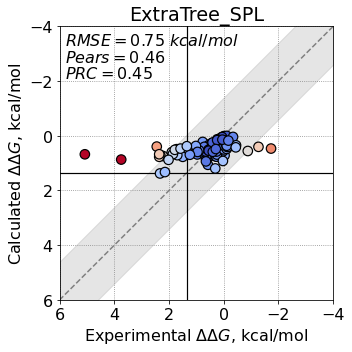

In [6]:
# ============
#    PLOT
# ============
T = 300
ddg_exp = pTest['DDG.EXP']
ddg_calc = pTest['DDG.ML1']

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5,5), sharex=False, sharey=False)

xlim = [-4, 6]
ylim = [-4, 6]

RMSE = get_rmse(ddg_exp, ddg_calc)
Pears = pearsonr(ddg_exp, ddg_calc)[0]
PRC = get_auc_prc(ddg_exp, ddg_calc)

plot_corr(ax, ddg_exp, ddg_calc, title='ExtraTree_SPL', fit=False, xlim=xlim, ylim=ylim)

annx = 5.8
anny = -3.3
asep = -0.6
fs = 16
_ = ax.annotate('$RMSE  = %.2f\ kcal/mol$' % (RMSE), xy=(annx, anny), zorder=10, fontsize=fs)
_ = ax.annotate('$Pears = %.2f$' % (Pears), xy=(annx, anny-asep), zorder=10, fontsize=fs)
_ = ax.annotate('$PRC   = %.2f$' % (PRC), xy=(annx, anny-2*asep), zorder=10, fontsize=fs)

# --------
# Fix look
# --------
ax.set_xticks([-4, -2, 0, 2, 4, 6])

plt.tight_layout()